# Plot Task Latencies
This notebook plots the latencies between consecutive tasks.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import re
import gzip
import os

## Plot Generated Ligand to Queue Latency

In [2]:
def get_process_ligands_latencies(run_dir: Path) -> pd.DataFrame:
    path = run_dir / "generation-results.json"
    task_dicts = []
    with open(path) as fp:
        for line in fp:
            row = json.loads(line)
            if row["method"] != "process_ligands":
                continue
            if "process_done" not in row["task_info"]:
                # Task failed
                continue
            task_dicts.append(
                {
                    "method": row["method"],
                    "ligand_id": row["task_info"]["task"][0],
                    "ligand_size": row["task_info"]["task"][1],
                    "model_version": row["task_info"]["model_version"],
                    "process_end_time": row["task_info"]["process_done"],
                    "generated_time": row["timestamp"]["created"],
                    "latency": row["task_info"]["process_done"]
                    - row["timestamp"]["created"],
                }
            )
    return pd.DataFrame(task_dicts)

In [3]:
DATE_PATTERN = "\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}"
PATTERN = re.compile(f"({DATE_PATTERN}).*mof=(mof-[a-z0-9]*):")


def get_sim_result_latencies(run_dir: Path) -> pd.DataFrame:
    sim_path = run_dir / "simulation-results.json"
    log_path = run_dir / "run.log"

    db_create = {}

    pattern = r""
    with open(log_path) as fp:
        for line in fp:
            if "Lattice change after MD simulation" in line:
                match = PATTERN.match(line)
                if match is None:
                    print(line)
                    raise AssertionError
                name = match.group(2)
                create_date = datetime.strptime(match.group(1), "%Y-%m-%d %H:%M:%S,%f")
                create_timestamp = datetime.timestamp(create_date)
                db_create[name] = create_timestamp

    task_dicts = []
    with open(sim_path) as fp:
        for line in fp:
            row = json.loads(line)
            if row["method"] != "run_molecular_dynamics":
                continue
            if not row["success"]:
                continue
            name = row["task_info"]["name"]
            write_time = db_create[name] if name in db_create else None
            latency = (
                write_time - row["timestamp"]["compute_ended"]
                if write_time is not None
                else None
            )
            task_dicts.append(
                {
                    "method": row["method"],
                    "name": name,
                    "simulation_end_time": row["timestamp"]["compute_ended"],
                    "database_write_time": write_time,
                    "latency": latency,
                }
            )

    return pd.DataFrame(task_dicts)

In [4]:
def get_retrain_latencies(run_dir: Path) -> pd.DataFrame:
    generate_path = run_dir / "generation-results.json"
    model_version_uses = defaultdict(list)
    with open(generate_path) as fp:
        for line in fp:
            row = json.loads(line)
            if row["method"] != "run_generator":
                continue
            model_version = row["task_info"]["model_version"]
            start_time = row["timestamp"]["compute_started"]
            model_version_uses[model_version].append(start_time)
    model_version_first_use = {
        key: min(values) for key, values in model_version_uses.items()
    }

    train_path = run_dir / "training-results.json"
    task_dicts = []
    model_index = 1
    with open(train_path) as fp:
        for line in fp:
            row = json.loads(line)
            if not row["success"]:
                continue

            available = row["timestamp"]["result_received"]
            if model_index in model_version_first_use:
                first_use = model_version_first_use[model_index]
            else:
                first_use = None
            task_dicts.append(
                {
                    "method": row["method"],
                    "model_version": model_index,
                    "result_received": available,
                    "first_generation_start": first_use,
                    "latency": first_use - available if first_use is not None else None,
                }
            )
            model_index += 1

    return pd.DataFrame(task_dicts)

In [5]:
def get_mof_latencies(run_dir: Path) -> pd.DataFrame:
    simulate_path = run_dir / "simulation-results.json"

    mof_events = defaultdict(dict)
    with open(simulate_path) as fp:
        for line in fp:
            row = json.loads(line)

            try:
                mof_name = row["task_info"]["name"]
            except:
                mof_name = row["task_info"]["mof"]

            method = row["method"]
            if method == "run_optimization":
                mof_events[mof_name]["run_optimization_done"] = row["timestamp"][
                    "compute_ended"
                ]
            elif method == "compute_partial_charges":
                mof_events[mof_name]["compute_partial_charges_start"] = row[
                    "timestamp"
                ]["compute_started"]
                mof_events[mof_name]["compute_partial_charges_done"] = row["timestamp"][
                    "compute_ended"
                ]
            elif method == "run_GCMC_single":
                mof_events[mof_name]["run_GCMC_single_start"] = row["timestamp"][
                    "compute_started"
                ]

    mof_events = [{"name": name, **events} for name, events in mof_events.items()]

    data = pd.DataFrame(mof_events)
    data["compute_partial_charges_latency"] = (
        data["compute_partial_charges_start"] - data["run_optimization_done"]
    )
    data["run_GCMC_single_latency"] = (
        data["run_GCMC_single_start"] - data["compute_partial_charges_done"]
    )

    return data

In [6]:
def plot_latency_distributions(run_dir):
    process_ligands_tasks = get_process_ligands_latencies(run_dir)
    sim_tasks = get_sim_result_latencies(run_dir)
    retrain_tasks = get_retrain_latencies(run_dir)
    mof_tasks = get_mof_latencies(run_dir)

    latencies = {
        "RDKit/OpenBabel": process_ligands_tasks["latency"].dropna().to_list(),
        "LAMMPS": sim_tasks["latency"].dropna().to_list(),
        "DiffLinker Train": retrain_tasks["latency"].dropna().to_list(),
        "Chargemol": mof_tasks["compute_partial_charges_latency"].dropna().to_list(),
        "RASPA": mof_tasks["run_GCMC_single_latency"].dropna().to_list(),
    }

    fig, ax = plt.subplots(figsize=(3.5, 2.25))

    # rectangular box plot
    bplot = ax.boxplot(
        list(reversed(latencies.values())),
        labels=list(reversed(latencies.keys())),
        vert=False,
    )
    ax.set_xlabel("Time (s)")

    plt.show()

/tmp/ipykernel_60895/3206193787.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


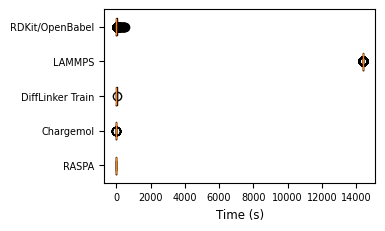

In [7]:
run_dir = Path("../prod-runs/128-nodes/")
plot_latency_distributions(run_dir)

In [ ]:
def gather_scaling_latencies(run_dirs, stddev: bool = True):
    latencies = []
    stddevs = []

    for nodes, path in tqdm(run_dirs.items()):
        process_ligands_tasks = get_process_ligands_latencies(path)
        sim_tasks = get_sim_result_latencies(path)
        retrain_tasks = get_retrain_latencies(path)
        mof_tasks = get_mof_latencies(path)

        process_ligands_latencies = process_ligands_tasks["latency"].dropna()
        sim_latencies = sim_tasks["latency"].dropna()
        retrain_latencies = (
            retrain_tasks["latency"].dropna()
            if len(retrain_tasks) > 0
            else np.array([])
        )
        compute_partial_latencies = mof_tasks[
            "compute_partial_charges_latency"
        ].dropna()
        run_gcmc_latencies = mof_tasks["run_GCMC_single_latency"].dropna()

        latencies.append(
            {
                "nodes": nodes,
                "path": path.name,
                "RDKit/OpenBabel": process_ligands_latencies.mean(),
                "LAMMPS": sim_latencies.mean(),
                "DiffLinker Train": retrain_latencies.mean(),
                "Chargemol": compute_partial_latencies.mean(),
                "RASPA": run_gcmc_latencies.mean(),
            }
        )

        if stddev:
            stddevs.append(
                {
                    "nodes": nodes,
                    "path": path.name,
                    "RDKit/OpenBabel": process_ligands_latencies.std(),
                    "LAMMPS": sim_latencies.std(),
                    "DiffLinker Train": retrain_latencies.std(),
                    "Chargemol": compute_partial_latencies.std(),
                    "RASPA": run_gcmc_latencies.std(),
                }
            )
        else:
            stddevs.append(
                {
                    "nodes": nodes,
                    "path": path.name,
                    "RDKit/OpenBabel": (
                        process_ligands_latencies.quantile(0.25),
                        process_ligands_latencies.quantile(0.75),
                    ),
                    "LAMMPS": (
                        sim_latencies.quantile(0.25),
                        sim_latencies.quantile(0.75),
                    ),
                    "DiffLinker Train": (
                        retrain_latencies.quantile(0.25),
                        retrain_latencies.quantile(0.75),
                    ),
                    "Chargemol": (
                        compute_partial_latencies.quantile(0.25),
                        compute_partial_latencies.quantile(0.75),
                    ),
                    "RASPA": (
                        run_gcmc_latencies.quantile(0.25),
                        run_gcmc_latencies.quantile(0.75),
                    ),
                }
            )

    latencies_df = pd.DataFrame(latencies).sort_values("nodes")
    stddevs_df = pd.DataFrame(stddevs).sort_values("nodes")
    return latencies_df, stddevs_df

In [29]:
def make_scaling_plot(latencies, stddevs, logy=False):
    nodes = sorted(latencies["nodes"].to_list())
    fig, ax = plt.subplots(figsize=(3.5, 2))

    # Drop the "nodes" and "path" column names
    kinds = list(latencies.keys())[2:]

    linestyles = ["-", "--", ":", "-.", (0, (3, 5, 1, 5, 1, 5))]
    markerstyles = ["o", "^", "v", "s", "d"]

    for i, kind in enumerate(kinds):
        err = pd.DataFrame(stddevs[kind].to_list()).transpose()
        ax.errorbar(
            # x=[x*(1 + 0.03*i) for x in latencies['nodes']],
            x=latencies["nodes"],
            y=latencies[kind],
            yerr=err,
            label=kind,
            # linestyle=linestyles[i],
            marker=markerstyles[i],
            capsize=2,
            elinewidth=0.75,
        )
    ax.set_ylabel("Latency (sec)", fontsize=8.5)
    ax.set_xlabel("Nodes", fontsize=8.5)
    if logy:
        ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=2)
    # ax.set_ylim([0, 60])

    handles, labels = ax.get_legend_handles_labels()
    # remove the errorbars
    handles = [h[0] for h in handles]
    # ax.legend(loc='upper center', fontsize=8, bbox_to_anchor=(0.5, -0.25), ncols=2)
    if not logy:
        ax.set_xticks(nodes)
        ax.set_xticklabels(nodes)
        ax.legend(
            handles, labels, loc="upper right", fontsize=6, bbox_to_anchor=(1.01, 1.01)
        )
    else:
        ax.set_yticks([0.01, 0.1, 1, 10, 100])
        ax.legend(
            handles,
            labels,
            loc="lower left",
            fontsize=6,
            bbox_to_anchor=(0, 0),
            ncols=2,
        )

    ax.tick_params(axis="x", labelsize=7)
    ax.tick_params(axis="y", labelsize=7)

    return fig

In [32]:
prod_runs_dir = Path("../prod-runs/")
prod_runs = {}
for d in prod_runs_dir.glob("*-nodes*"):
    nodes = int(d.name.split("-")[0])
    prod_runs[d] = d.absolute()

latencies, stddevs = gather_scaling_latencies(prod_runs, stddev=True)
latencies.head()

  8%|██████████████████▏                                                                                                                                                                                                       | 1/12 [00:07<01:23,  7.62s/it]/tmp/ipykernel_60895/1082705973.py:22: RuntimeWarning: Mean of empty slice.
  'DiffLinker Train': retrain_latencies.mean(),
/home/lward/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lward/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lward/miniconda3/envs/mofa/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lward/miniconda3/envs/mofa/lib/pyt

,nodes,path,RDKit/OpenBabel,LAMMPS,DiffLinker Train,Chargemol,RASPA
4,../prod-runs/128-nodes,128-nodes,17.312320,14400.060039,9.361567,0.653458,2.411884
6,../prod-runs/256-nodes,256-nodes,18.214188,14400.072146,6.493562,0.548129,2.310976
2,../prod-runs/32-nodes_no-retrain,32-nodes_no-retrain,14.040884,14400.058084,NaN,0.367635,4.320696
7,../prod-runs/32-nodes_repeat-1,32-nodes_repeat-1,25.464398,14400.061779,42.362898,1.128161,2.694254
11,../prod-runs/32-nodes_repeat-2,32-nodes_repeat-2,16.521900,14400.058107,33.365839,0.395319,4.428928


In [33]:
latencies

,nodes,path,RDKit/OpenBabel,LAMMPS,DiffLinker Train,Chargemol,RASPA
4,../prod-runs/128-nodes,128-nodes,17.312320,14400.060039,9.361567,0.653458,2.411884
6,../prod-runs/256-nodes,256-nodes,18.214188,14400.072146,6.493562,0.548129,2.310976
2,../prod-runs/32-nodes_no-retrain,32-nodes_no-retrain,14.040884,14400.058084,NaN,0.367635,4.320696
7,../prod-runs/32-nodes_repeat-1,32-nodes_repeat-1,25.464398,14400.061779,42.362898,1.128161,2.694254
11,../prod-runs/32-nodes_repeat-2,32-nodes_repeat-2,16.521900,14400.058107,33.365839,0.395319,4.428928
0,../prod-runs/450-nodes,450-nodes,15.526346,14400.195461,2.288233,0.320065,1.151098
5,../prod-runs/64-nodes_no-proxystore,64-nodes_no-proxystore,16.872783,14400.069439,14.361437,1.306288,5.529624
8,../prod-runs/64-nodes_no-retrain,64-nodes_no-retrain,13.564708,14400.058790,NaN,0.898215,3.560774
3,../prod-runs/64-nodes_no-retrain_repeat-2,64-nodes_no-retrain_repeat-2,13.616227,14400.058761,NaN,1.134600,4.123784
1,../prod-runs/64-nodes_no-stream,64-nodes_no-stream,103.116890,14400.062349,NaN,2.635761,2.967038


In [12]:
fig = make_scaling_plot(latencies, stddevs, logy=True)
fig.tight_layout(pad=0.2)
fig.savefig("figures/scaling-latencies.pdf")